In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## Reading and investigating the data

In [2]:
data = pd.read_csv('bankdata.csv')

In [3]:
data.shape

(74364, 9)

In [4]:
data.dtypes

type             object
operation        object
amount_total    float64
balance         float64
k_symbol         object
amount_left       int64
duration          int64
payments        float64
status           object
dtype: object

In [5]:
data.head()

,type,operation,amount_total,balance,k_symbol,amount_left,duration,payments,status
0,PRIJEM,prevod,44749.0,45549.0,unknown,79608,24,3317.0,A
1,PRIJEM,vklad,1000.0,1000.0,unknown,52788,12,4399.0,A
2,PRIJEM,vklad,1100.0,1100.0,unknown,21924,36,609.0,A
3,PRIJEM,vklad,700.0,700.0,unknown,23052,12,1921.0,A
4,PRIJEM,vklad,900.0,900.0,unknown,41904,12,3492.0,A


In [6]:
data["status"].value_counts()

A    64599
B     9765
Name: status, dtype: int64

In [7]:
# What would be interesting questions to model out of the data with supervised algorithm?
#-How likely are you to default?So to predict the status for a customer.
# So we would like to predict if a new customer has status A or B based on the variables we have!

#Every row is one account

### Investigating the numerical variables

In [8]:
data.describe()

# Note: when mean and median are far away: skewed data

# variance/std differ a lot between values. When alg is sensitive for that, you have to be careful. 
# Decision trees are robust to that

,amount_total,balance,amount_left,duration,payments
count,74364.000000,74364.000000,74364.000000,74364.000000,74364.000000
mean,7832.649125,46022.153061,102745.132645,23.942230,4356.580832
std,11729.040391,25439.948570,74749.275498,12.155783,2205.840892
min,0.000000,-14137.200000,4980.000000,12.000000,319.000000
25%,144.300000,27675.125000,46320.000000,12.000000,2569.000000
50%,3000.000000,40965.150000,86184.000000,24.000000,4051.000000
75%,9868.500000,60098.550000,140400.000000,36.000000,6315.000000
max,87300.000000,193910.000000,464520.000000,60.000000,9736.000000


#### Investigating variable duration

In [9]:
data['duration'].value_counts()

# month im comparison to moneatry values.
# But it is also not a continous quantity, so we will convert it in categorical variable

12    28761
24    25155
36    14110
48     4721
60     1617
Name: duration, dtype: int64

In [10]:
# we will convert this to a categorical
data['duration'] = data['duration'].apply(str)

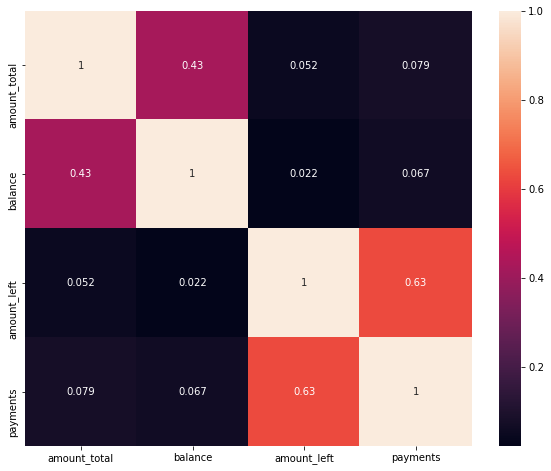

In [11]:
# Checking for multicollinearity
plt.figure(figsize=(10, 8))
ax = sns.heatmap(data.corr(), annot=True)
plt.show()

#### payments and amount_left have a rather high correlation, so we will include only one of them in the model

C:\Users\broth\anaconda3\envs\kittycat\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


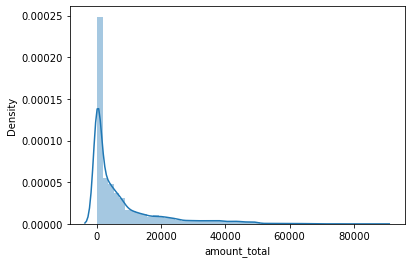

In [12]:
sns.distplot(data['amount_total'])
plt.show()

C:\Users\broth\anaconda3\envs\kittycat\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


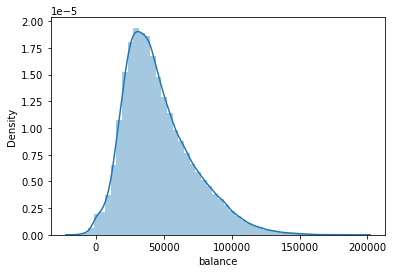

In [13]:
sns.distplot(data['balance'])
plt.show()

C:\Users\broth\anaconda3\envs\kittycat\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


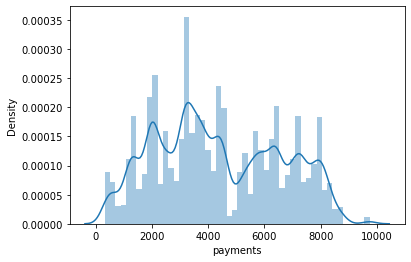

In [14]:
sns.distplot(data['payments'])
plt.show()

### Preprocessing the numerical variables

data pre-processing:
- remove or fillmissing values
- transform categorical/ordinal into numerical values
- deal with outliers (since they will skew fit of model)
- creating new features from existing ones; Goal is to achieve better ML result

scaling possibilites:
- Standardization: transforms distribution to mean = 0 and Std = 1: For each datapoint subtract maen and divide by Std
- Normalization: All values between 0 and 1; for each datapoint subtract minimum and divide by (max-min)
usw.

Reason for scaling:
For example Regrsssion:
different scales impacts importance of different variables as scale affects coefficients

In [15]:
# we are interested in prediction, not in interpreating the coefficients; therefore we can easily standardize the variables

from sklearn.preprocessing import StandardScaler
data_num = data.select_dtypes(include = np.number).drop(columns = 'amount_left')
# selecting just numerical variables and dropping amount_left from it as we decided not to use it any further
print(data_num.head())
# Standardizing data
transformer = StandardScaler().fit(data_num)
data_num_standardized = transformer.transform(data_num)
x = pd.DataFrame(data_num_standardized, columns = data_num.columns)
print(x.head())

   amount_total  balance  payments
0       44749.0  45549.0    3317.0
1        1000.0   1000.0    4399.0
2        1100.0   1100.0     609.0
3         700.0    700.0    1921.0
4         900.0    900.0    3492.0
   amount_total   balance  payments
0      3.147453 -0.018599 -0.471289
1     -0.582545 -1.769754  0.019231
2     -0.574019 -1.765823 -1.698947
3     -0.608123 -1.781547 -1.104158
4     -0.591071 -1.773685 -0.391953


C:\Users\broth\anaconda3\envs\kittycat\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


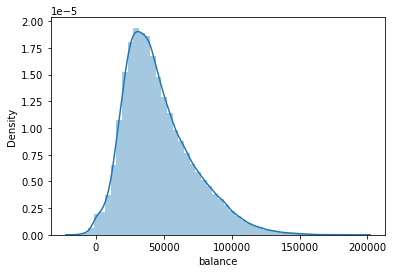

In [16]:
sns.distplot(data['balance'])
plt.show()

C:\Users\broth\anaconda3\envs\kittycat\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


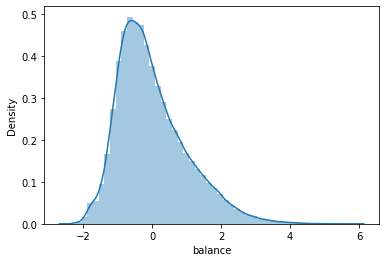

In [17]:
sns.distplot(x['balance'])
plt.show()

In [18]:
# distributional shape basically stays the same. Just mean and variance is standardized. 
# Not absolutely necessary for desicion trees, but for others and it does not hurt desicion trees

### Getting dummies for the categorical variables

In [19]:
from sklearn.preprocessing import OneHotEncoder
cat = data.select_dtypes(include = np.object).drop(columns = 'status')
# dropping status as this is dependent variable
enc = OneHotEncoder(drop = "first")
categorical = pd.DataFrame(enc.fit_transform(cat).toarray(), columns = enc.get_feature_names())
categorical.head()

,x0_VYBER,x0_VYDAJ,x1_unknown,x1_vklad,x1_vyber,x2_sankc. urok,x2_sipo,x2_sluzby,x2_unknown,x2_urok,x2_uver,x3_24,x3_36,x3_48,x3_60
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
categorical.sum(axis = 1)
# checking for correctness, 4 as we have 4 categorical values

0        2.0
1        2.0
2        3.0
3        2.0
4        2.0
        ... 
74359    3.0
74360    3.0
74361    3.0
74362    3.0
74363    3.0
Length: 74364, dtype: float64

In [21]:
y = data['status']
X = pd.concat((x, categorical), axis=1)
X.head()

,amount_total,balance,payments,x0_VYBER,x0_VYDAJ,x1_unknown,x1_vklad,x1_vyber,x2_sankc. urok,x2_sipo,x2_sluzby,x2_unknown,x2_urok,x2_uver,x3_24,x3_36,x3_48,x3_60
0,3.147453,-0.018599,-0.471289,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,-0.582545,-1.769754,0.019231,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.574019,-1.765823,-1.698947,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,-0.608123,-1.781547,-1.104158,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.591071,-1.773685,-0.391953,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Splitting into train and test set

In [22]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=100)

#random_state: to make sure same rows are selected when I run it a second time as far as I add any random number to it
# the number is so to say a name

# random selecting for time series:
#data.loc[] to choose the first each rows

### Logistic Regression

In [23]:
from sklearn.linear_model import LogisticRegression
logisticr = LogisticRegression(max_iter = 500).fit(X_train, y_train)

In [24]:
predictions = logisticr.predict(X_test)
logisticr.score(X_test, y_test)

#score tells us accuracy.It means we predict 88% of our observations in test set correctly.

0.8806898406508438

In [25]:
print(y_test.value_counts())

A    25839
B     3907
Name: status, dtype: int64


In [26]:
pd.Series(predictions).value_counts()

A    29120
B      626
dtype: int64

In [27]:
#What happened in terms of the classes?
#We are bad at predicting B; bad at minority class - so we did systematic mistakes.

### Decision Tree

In [28]:
from sklearn.tree import DecisionTreeClassifier
decisiontree = DecisionTreeClassifier().fit(X_train, y_train)

In [29]:
predictions = decisiontree.predict(X_test)
decisiontree.score(X_test, y_test)

# good at decision trees is that we can deal with non-lineary, which log regression could not handle

0.9950245411147718

In [30]:
pd.Series(predictions).value_counts()

A    25819
B     3927
dtype: int64

In [31]:
decisiontree.feature_importances_

#the higher the value, the more important the feature; ordered in same way like our features
# most important features for target variable

array([1.43562567e-02, 1.21893462e-01, 6.87856201e-01, 5.84855729e-04,
       2.20691646e-03, 6.54044895e-04, 1.65005260e-03, 1.61403059e-03,
       0.00000000e+00, 4.49245374e-04, 3.60814265e-05, 4.42391600e-04,
       1.82243949e-05, 3.81678019e-04, 8.11523011e-02, 4.13979776e-02,
       8.47162746e-03, 3.68346534e-02])

In [32]:
print(dict(zip(X.columns, decisiontree.feature_importances_)))



{'amount_total': 0.014356256744473776, 'balance': 0.12189346178814901, 'payments': 0.6878562008400595, 'x0_VYBER': 0.0005848557293973858, 'x0_VYDAJ': 0.0022069164643885087, 'x1_unknown': 0.0006540448954304196, 'x1_vklad': 0.0016500526028053655, 'x1_vyber': 0.0016140305918257544, 'x2_sankc. urok': 0.0, 'x2_sipo': 0.00044924537401707504, 'x2_sluzby': 3.608142650231835e-05, 'x2_unknown': 0.00044239160019014936, 'x2_urok': 1.822439494868108e-05, 'x2_uver': 0.0003816780194396257, 'x3_24': 0.08115230111021896, 'x3_36': 0.04139797755998726, 'x3_48': 0.008471627461195242, 'x3_60': 0.036834653396971014}


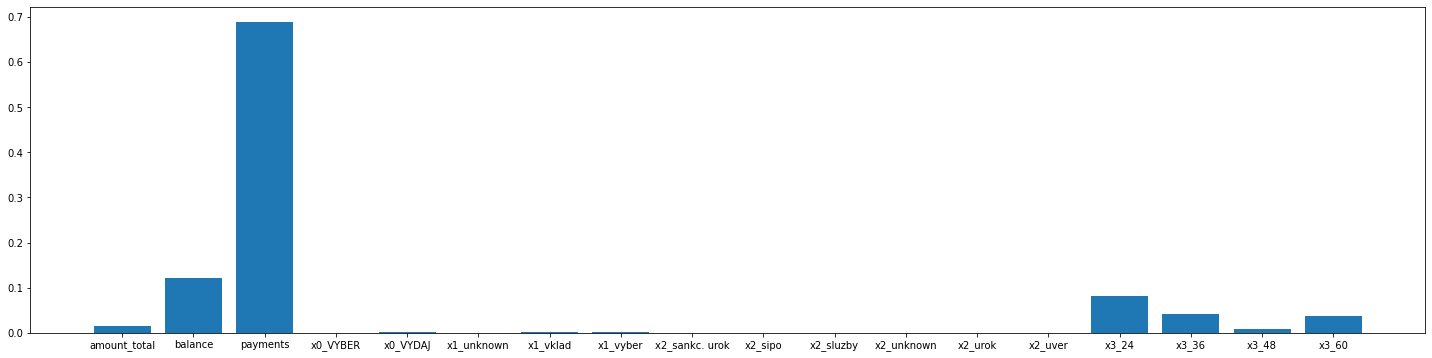

In [33]:
plt.rcParams['figure.figsize'] = [25, 6]
plt.bar(height = decisiontree.feature_importances_, x = X.columns)
plt.show()

### SVM

In [34]:
from sklearn.svm import SVC

svm = SVC().fit(X_train, y_train)
predictions = svm.predict(X_test)
print(svm.score(X_test, y_test))
print(pd.Series(predictions).value_counts())

# SVM is not very scalable, when dataset becomes larger as it takes a lot of time to run
# A = Majority class
# B = Minority class

0.8984737443689907
A    28635
B     1111
dtype: int64


In [35]:
help(SVC)
# SVC uses linear kernel; like linear line -> ususally behaves a little bit worse than datadriven shaped kernel

Help on class SVC in module sklearn.svm._classes:

class SVC(sklearn.svm._base.BaseSVC)
 |  SVC(*, C=1.0, kernel='rbf', degree=3, gamma='scale', coef0=0.0, shrinking=True, probability=False, tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=-1, decision_function_shape='ovr', break_ties=False, random_state=None)
 |  
 |  C-Support Vector Classification.
 |  
 |  The implementation is based on libsvm. The fit time scales at least
 |  quadratically with the number of samples and may be impractical
 |  beyond tens of thousands of samples. For large datasets
 |  consider using :class:`sklearn.svm.LinearSVC` or
 |  :class:`sklearn.linear_model.SGDClassifier` instead, possibly after a
 |  :class:`sklearn.kernel_approximation.Nystroem` transformer.
 |  
 |  The multiclass support is handled according to a one-vs-one scheme.
 |  
 |  For details on the precise mathematical formulation of the provided
 |  kernel functions and how `gamma`, `coef0` and `degree` affect each
 |  

### K-Nearest Neighbors

In [36]:
from sklearn.neighbors import KNeighborsClassifier

nearest_neighbors = KNeighborsClassifier().fit(X_train, y_train)
predictions = nearest_neighbors.predict(X_test)
print(nearest_neighbors.score(X_test, y_test))
print(pd.Series(predictions).value_counts())

# More scalable than SCV
# Performs awesome on minority class

0.9264102736502386
A    26682
B     3064
dtype: int64


In [37]:
help(KNeighborsClassifier)
# K-Paramters:how many neighbours to take into account.5 equals default

Help on class KNeighborsClassifier in module sklearn.neighbors._classification:

class KNeighborsClassifier(sklearn.neighbors._base.NeighborsBase, sklearn.neighbors._base.KNeighborsMixin, sklearn.neighbors._base.SupervisedIntegerMixin, sklearn.base.ClassifierMixin)
 |  KNeighborsClassifier(n_neighbors=5, *, weights='uniform', algorithm='auto', leaf_size=30, p=2, metric='minkowski', metric_params=None, n_jobs=None, **kwargs)
 |  
 |  Classifier implementing the k-nearest neighbors vote.
 |  
 |  Read more in the :ref:`User Guide <classification>`.
 |  
 |  Parameters
 |  ----------
 |  n_neighbors : int, default=5
 |      Number of neighbors to use by default for :meth:`kneighbors` queries.
 |  
 |  weights : {'uniform', 'distance'} or callable, default='uniform'
 |      weight function used in prediction.  Possible values:
 |  
 |      - 'uniform' : uniform weights.  All points in each neighborhood
 |        are weighted equally.
 |      - 'distance' : weight points by the inverse of t

### Supervised Learning: Regression

In [38]:
# Decision Tree
from sklearn.tree import DecisionTreeRegressor
# SVR
from sklearn.svm import SVR
# KNN
from sklearn.neighbors import KNeighborsRegressor

## Model Evaluation

### Creating the Confusion Matrix

In [39]:
from sklearn.linear_model import LogisticRegression
logisticr = LogisticRegression().fit(X_train, y_train)

In [40]:
predictions = logisticr.predict(X_test)
logisticr.score(X_test, y_test)

0.8806898406508438

In [41]:
pd.Series(predictions).value_counts()

A    29120
B      626
dtype: int64

In [42]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_test, predictions)
print(cf_matrix)

# left side is A
# right side is B
# On main diagonal, we have correctly classified data. Always!
# we try to get main diagonal values as high as possible. Always!
# x-axis is what they truely are, y-axis is what we predict

[[25705   134]
 [ 3415   492]]


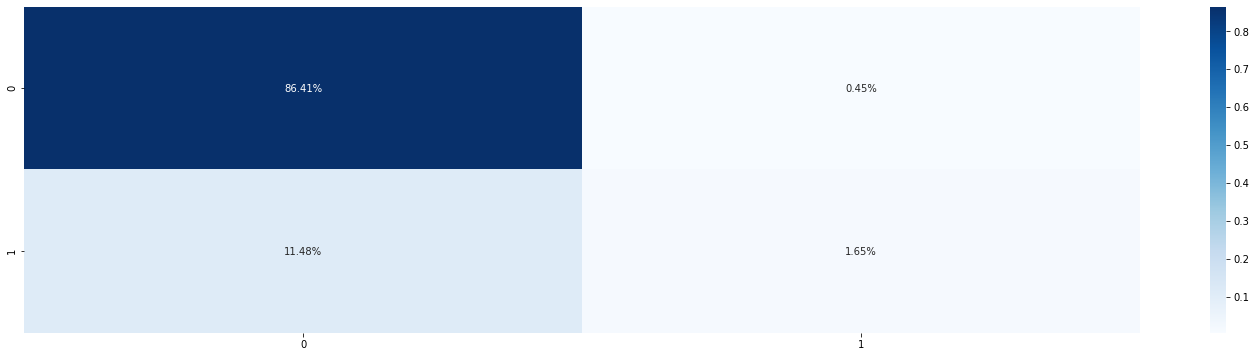

In [43]:
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')
plt.show()
# 1/1 is true positive in this case
# 0/0 are true negative in this case
# 0/1 (11,48%),we think they are fine, but they are not in reality
# ! Be careful, Order depends on alphabet of my labels! So you can not always say where true/positive etc. will be located!

#### Precision, Recall and the F1 Score

In [44]:
from sklearn.metrics import precision_score, recall_score, f1_score
# We need to assign which is the 'positive class'. Here, we are trying to predict whether a customer will run into
# problems repaying their loan. So Status B is the 'positive' class (meaning credit problems = True)
print(precision_score(y_test, predictions, pos_label='B'))
print(recall_score(y_test, predictions, pos_label='B'))
print(f1_score(y_test, predictions, pos_label='B'))
# precision: 78% of people for which I predicted credit problems, really had ones
# recall: 12% of people who had credit problems, I identified as people with credit problems
# f1_score: harmonic mean, of the two before. Tells about how well model is doing
# Accuracy score just good im comparison to f1_score because of class inbalance

0.7859424920127795
0.12592782185820323
0.2170747849106552


In [45]:
from sklearn.metrics import balanced_accuracy_score
balanced_accuracy_score(y_test, predictions)
# average of recall for both classes - recall class A and recall class B

0.5603709313246278

#### ROC and AUC analysis

In [46]:
from sklearn.metrics import roc_curve, roc_auc_score
help(roc_curve)

Help on function roc_curve in module sklearn.metrics._ranking:

roc_curve(y_true, y_score, *, pos_label=None, sample_weight=None, drop_intermediate=True)
    Compute Receiver operating characteristic (ROC)
    
    Note: this implementation is restricted to the binary classification task.
    
    Read more in the :ref:`User Guide <roc_metrics>`.
    
    Parameters
    ----------
    
    y_true : array, shape = [n_samples]
        True binary labels. If labels are not either {-1, 1} or {0, 1}, then
        pos_label should be explicitly given.
    
    y_score : array, shape = [n_samples]
        Target scores, can either be probability estimates of the positive
        class, confidence values, or non-thresholded measure of decisions
        (as returned by "decision_function" on some classifiers).
    
    pos_label : int or str, default=None
        The label of the positive class.
        When ``pos_label=None``, if y_true is in {-1, 1} or {0, 1},
        ``pos_label`` is set to 

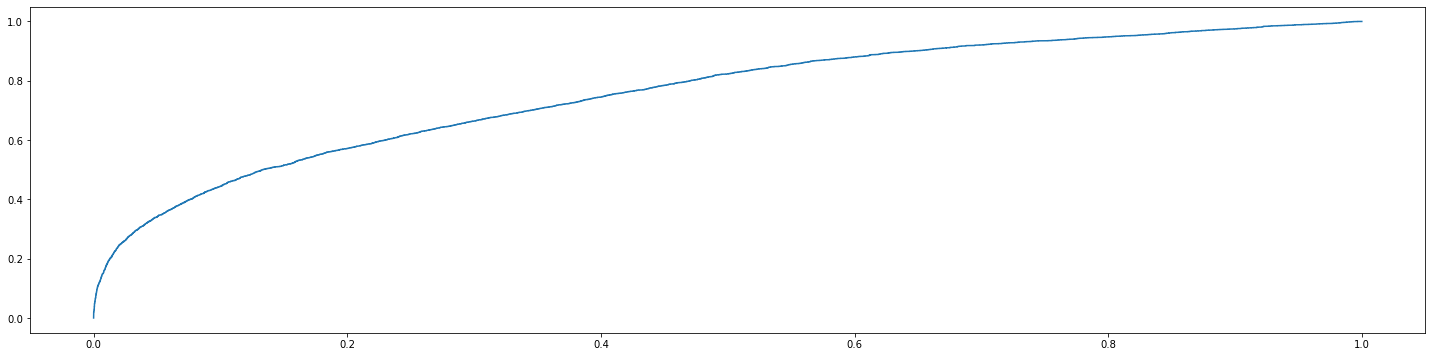

In [47]:
# we need to calculate class probabilities!
y_pred_proba = logisticr.predict_proba(X_test)[:,1]
# predicts prob for class b for every row in dataset, which is positive for us in our case
fpr, tpr, _ = roc_curve(y_test, y_pred_proba, pos_label='B') 
plt.plot(fpr,tpr)
plt.show()

In [48]:
help(roc_auc_score)

Help on function roc_auc_score in module sklearn.metrics._ranking:

roc_auc_score(y_true, y_score, *, average='macro', sample_weight=None, max_fpr=None, multi_class='raise', labels=None)
    Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC)
    from prediction scores.
    
    Note: this implementation can be used with binary, multiclass and
    multilabel classification, but some restrictions apply (see Parameters).
    
    Read more in the :ref:`User Guide <roc_metrics>`.
    
    Parameters
    ----------
    y_true : array-like of shape (n_samples,) or (n_samples, n_classes)
        True labels or binary label indicators. The binary and multiclass cases
        expect labels with shape (n_samples,) while the multilabel case expects
        binary label indicators with shape (n_samples, n_classes).
    
    y_score : array-like of shape (n_samples,) or (n_samples, n_classes)
        Target scores. In the binary and multilabel cases, these can be either
      

In [49]:
roc_auc_score(y_test, y_pred_proba)
# always between 0.5 and 1, as its Area under curve
# other measurement for wellness of my classification

0.7585273887872525

### Repeating all the steps for a Decision Tree for comparison:

In [50]:
from sklearn.tree import DecisionTreeClassifier
decisiontree = DecisionTreeClassifier().fit(X_train, y_train)

In [51]:
predictions = decisiontree.predict(X_test)
decisiontree.score(X_test, y_test)
#accuracy

0.9951590129765346

In [52]:
cf_matrix = confusion_matrix(y_test, predictions)
print(cf_matrix)
# most data on main diagonal, so we mainly have true positives and true negatives

[[25757    82]
 [   62  3845]]


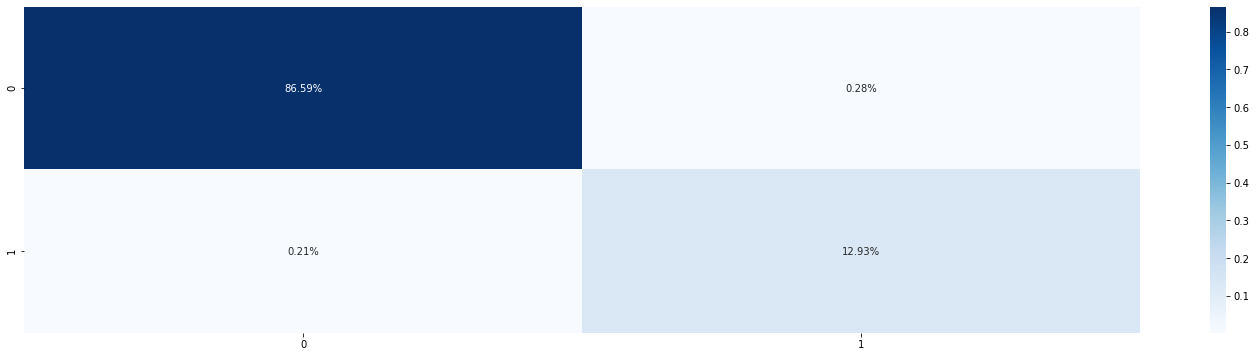

In [53]:
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')
plt.show()

In [54]:
print(precision_score(y_test, predictions, pos_label='B'))
print(recall_score(y_test, predictions, pos_label='B'))
print(f1_score(y_test, predictions, pos_label='B'))

0.9791189202953909
0.9841310468390069
0.981618585652285


In [55]:
balanced_accuracy_score(y_test, predictions)

0.990478774706318

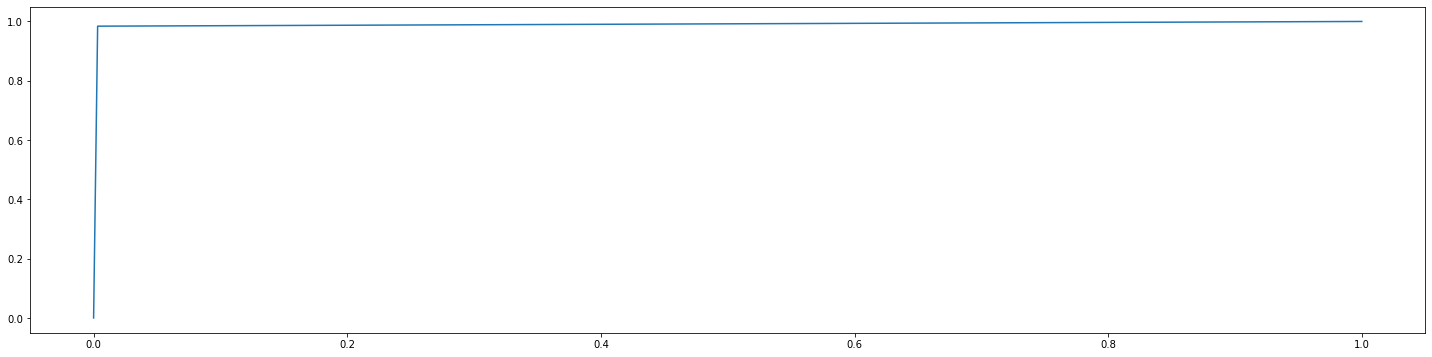

In [56]:
y_pred_proba = decisiontree.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba, pos_label='B') 
# we need to assign which one is the "positive" (1) category
plt.plot(fpr,tpr)
plt.show()

In [57]:
roc_auc_score(y_test, y_pred_proba)

0.9904787747063181

### Hyperparameter Tuning

Can we do even better?

In [58]:
from sklearn.model_selection import GridSearchCV
help(GridSearchCV)
# function to support hyperparamter tuning
# you give it what alg we want to use and a bunch of paramters we want to try for this alg
# Than this function tries all different combination of paramters by its own and tell perfect score for each
# The score to improve model on is always .score(), but you can specify other values to improve on like "recall" for example
# Grid function also works for regression, there we can give different regression algs to test for and find best regression alg

# We usually evaluatew regrssions based on: R, MSE;RMSE

Help on class GridSearchCV in module sklearn.model_selection._search:

class GridSearchCV(BaseSearchCV)
 |  GridSearchCV(estimator, param_grid, *, scoring=None, n_jobs=None, iid='deprecated', refit=True, cv=None, verbose=0, pre_dispatch='2*n_jobs', error_score=nan, return_train_score=False)
 |  
 |  Exhaustive search over specified parameter values for an estimator.
 |  
 |  Important members are fit, predict.
 |  
 |  GridSearchCV implements a "fit" and a "score" method.
 |  It also implements "predict", "predict_proba", "decision_function",
 |  "transform" and "inverse_transform" if they are implemented in the
 |  estimator used.
 |  
 |  The parameters of the estimator used to apply these methods are optimized
 |  by cross-validated grid-search over a parameter grid.
 |  
 |  Read more in the :ref:`User Guide <grid_search>`.
 |  
 |  Parameters
 |  ----------
 |  estimator : estimator object.
 |      This is assumed to implement the scikit-learn estimator interface.
 |      Either e

In [59]:
help(DecisionTreeClassifier)
# shows you all parameters, that exist for DecisionTrees
# for example max_depth is an imüportant paramter for desicion trees. Always make sure it is not infinite to prevent overfitting 

Help on class DecisionTreeClassifier in module sklearn.tree._classes:

class DecisionTreeClassifier(sklearn.base.ClassifierMixin, BaseDecisionTree)
 |  DecisionTreeClassifier(*, criterion='gini', splitter='best', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, class_weight=None, presort='deprecated', ccp_alpha=0.0)
 |  
 |  A decision tree classifier.
 |  
 |  Read more in the :ref:`User Guide <tree>`.
 |  
 |  Parameters
 |  ----------
 |  criterion : {"gini", "entropy"}, default="gini"
 |      The function to measure the quality of a split. Supported criteria are
 |      "gini" for the Gini impurity and "entropy" for the information gain.
 |  
 |  splitter : {"best", "random"}, default="best"
 |      The strategy used to choose the split at each node. Supported
 |      strategies are "best" to choose the best split and "random" to choos

In [69]:
param_grid_rf = {"criterion": ["gini", "entropy"],
                 "splitter": ["best", "random"],
                 "max_depth": [3, 10, None]}

# we give a dictonary to function with all criteriums and the values we want to test for these criteriums 

tune_rf = GridSearchCV(DecisionTreeClassifier(),
                       param_grid=param_grid_rf,
                       cv=3)

tune_rf.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 10, None],
                         'splitter': ['best', 'random']})

In [61]:
tune_rf.best_params_

{'criterion': 'entropy', 'max_depth': None, 'splitter': 'best'}

In [62]:
decisiontree_opt = DecisionTreeClassifier(**tune_rf.best_params_).fit(X_train, y_train)
# "**" makes sure we do not just copy the output in dict form as we get it, but we need it with equal signs, therefore **
# often used for function arguments, which are specified somewhere else

In [63]:
predictions = decisiontree_opt.predict(X_test)
decisiontree_opt.score(X_test, y_test)

0.99586499025079

In [64]:
cf_matrix = confusion_matrix(y_test, predictions)
print(cf_matrix)

[[25770    69]
 [   54  3853]]


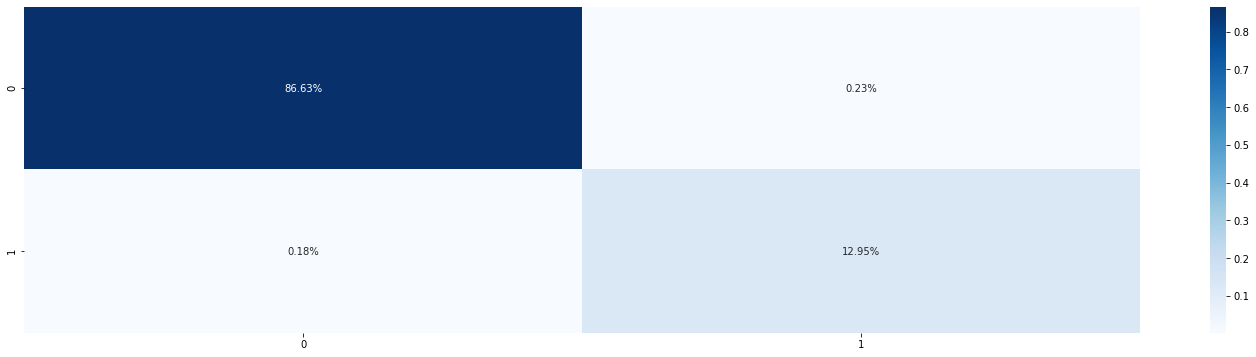

In [65]:
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')
plt.show()

In [66]:
print(precision_score(y_test, predictions, pos_label='B'))
print(recall_score(y_test, predictions, pos_label='B'))
print(f1_score(y_test, predictions, pos_label='B'))

0.982406935237124
0.9861786536984899
0.9842891812492017


In [67]:
balanced_accuracy_score(y_test, predictions)

0.9917541358588815

#### We can even extend this to multiple algorithms!

In [70]:
# the models that you want to compare
models = {
    'DecisionTreeClassifier': DecisionTreeClassifier(),
    'LogisticRegression': LogisticRegression()
}

# the optimisation parameters for each of the models that you have picked above (check their help functions!!)
params = {
    'DecisionTreeClassifier':
        {'criterion': ['gini', 'entropy'],
                 'splitter': ['best', 'random'],
                 'max_depth': [3, 10, None]
        },
    'LogisticRegression': {
        'solver': ['newton-cg', 'sag', 'lbfgs'],
        'multi_class': ['ovr', 'multinomial']
        }  
}

# two dicts: one for the models and one for the paramters and their values

In [71]:
for model in models.keys():
    tune = GridSearchCV(estimator=models[model], param_grid=params[model], cv=3)
    tune.fit(X_train, y_train)
    print("Best estimator is {}".format(tune.best_estimator_))
    print("Best parameters are: {}".format(tune.best_params_))
    print("Best score is: {}".format(tune.best_score_))    
# use for loop to check for both models best values for their paramters  
# print("hello {}{}".format("world","!"))  -> a way to define strings; several of these exisit
# R string & F string other ways to concatinate strings
# ("hello", "world").join(" ") another way

Best estimator is DecisionTreeClassifier(criterion='entropy')
Best parameters are: {'criterion': 'entropy', 'max_depth': None, 'splitter': 'best'}
Best score is: 0.9953382093307823
Best estimator is LogisticRegression(multi_class='ovr')
Best parameters are: {'multi_class': 'ovr', 'solver': 'lbfgs'}
Best score is: 0.8798691044700852


### Cross Validation

Is our split into training and test set biased?

In [72]:
from sklearn.model_selection import cross_validate
help(cross_validate)

# splits our data several times randomly to make sure our split is not biased

Help on function cross_validate in module sklearn.model_selection._validation:

cross_validate(estimator, X, y=None, *, groups=None, scoring=None, cv=None, n_jobs=None, verbose=0, fit_params=None, pre_dispatch='2*n_jobs', return_train_score=False, return_estimator=False, error_score=nan)
    Evaluate metric(s) by cross-validation and also record fit/score times.
    
    Read more in the :ref:`User Guide <multimetric_cross_validation>`.
    
    Parameters
    ----------
    estimator : estimator object implementing 'fit'
        The object to use to fit the data.
    
    X : array-like of shape (n_samples, n_features)
        The data to fit. Can be for example a list, or an array.
    
    y : array-like of shape (n_samples,) or (n_samples, n_outputs),             default=None
        The target variable to try to predict in the case of
        supervised learning.
    
    groups : array-like of shape (n_samples,), default=None
        Group labels for the samples used while splitt

In [73]:
cross_validate(DecisionTreeClassifier(),
               X_train,
               y_train,
               scoring="balanced_accuracy")
# also works with giving x and y completely or x_train and y_train
# balanced_accuracy is one option of a test score to use here, default ist just model.score() (=basic accuracy)
# you could for example also use racall score for that
# for classiication problem usually just accuracy is not the best one, therefore we used balanced_accuracy here
# at the end what to choose, depends on your problem and what you want
# by default splits 5 time differently, but always the same amount assigned to train and split

{'fit_time': array([0.11316705, 0.10874343, 0.10441613, 0.11067963, 0.12263989]),
 'score_time': array([0.02393603, 0.02393556, 0.02194071, 0.02493262, 0.02297258]),
 'test_score': array([0.98673974, 0.98710186, 0.99030659, 0.98987231, 0.9896543 ])}

In [74]:
cross_validate(DecisionTreeClassifier(),
               X_train,
               y_train,
               scoring="balanced_accuracy")["test_score"].mean()
# test_score is than cross_validated, which means that you now know that it is more robust as its the result of splitting in
# train and test differently for 5 times

# makes your model more robust

0.988504643750797

## Pretending this was a multiclass problem

In [75]:
y_train[:5000] = 'C'
y_test[:5000] = 'C'

In [76]:
decisiontree = DecisionTreeClassifier().fit(X_train, y_train)
predictions = decisiontree.predict(X_test)
decisiontree.score(X_test, y_test)

0.7464869226114436

In [77]:
cf_matrix = confusion_matrix(y_test, predictions)
print(cf_matrix)

[[18849    55  2618]
 [   46  2769   409]
 [ 3796   617   587]]


In [78]:
help(precision_score)

Help on function precision_score in module sklearn.metrics._classification:

precision_score(y_true, y_pred, *, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn')
    Compute the precision
    
    The precision is the ratio ``tp / (tp + fp)`` where ``tp`` is the number of
    true positives and ``fp`` the number of false positives. The precision is
    intuitively the ability of the classifier not to label as positive a sample
    that is negative.
    
    The best value is 1 and the worst value is 0.
    
    Read more in the :ref:`User Guide <precision_recall_f_measure_metrics>`.
    
    Parameters
    ----------
    y_true : 1d array-like, or label indicator array / sparse matrix
        Ground truth (correct) target values.
    
    y_pred : 1d array-like, or label indicator array / sparse matrix
        Estimated targets as returned by a classifier.
    
    labels : list, optional
        The set of labels to include when ``average != 'binary

In [79]:
print(precision_score(y_test, predictions, average = 'macro')) # macro it will do precision for each class and then average
print(recall_score(y_test, predictions, average = 'macro')) 
print(f1_score(y_test, predictions, average = 'macro'))

0.5992712029567687
0.6173574910594111
0.6066142124675948


In [80]:
# if None will just return the score for each class individually
print(precision_score(y_test, predictions, average = None))

[0.83068177 0.80470793 0.16242391]


In [81]:
balanced_accuracy_score(y_test, predictions)
# average recall for all classes

0.6173574910594111